# Digits classification usign MNIST dataset

In [1]:
from __future__ import print_function, division, unicode_literals

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist

{'data': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'target': array(['5', '0', '4', ..., '4', '5', '6'], dtype=object),
 'feature_names': ['pixel1',
  'pixel2',
  'pixel3',
  'pixel4',
  'pixel5',
  'pixel6',
  'pixel7',
  'pixel8',
  'pixel9',
  'pixel10',
  'pixel11',
  'pixel12',
  'pixel13',
  'pixel14',
  'pixel15',
  'pixel16',
  'pixel17',
  'pixel18',
  'pixel19',
  'pixel20',
  'pixel21',
  'pixel22',
  'pixel23',
  'pixel24',
  'pixel25',
  'pixel26',
  'pixel27',
  'pixel28',
  'pixel29',
  'pixel30',
  'pixel31',
  'pixel32',
  'pixel33',
  'pixel34',
  'pixel35',
  'pixel36',
  'pixel37',
  'pixel38',
  'pixel39',
  'pixel40',
  'pixel41',
  'pixel42',
  'pixel43',
  'pixel44',
  'pixel45',
  'pixel46',
  'pixel47',
  'pixel48',
  'pixel49',
  'pixel50',
  'pixel51',
  '

In [3]:
def sort_by_target(mnist): 
    #fetch_openml() returns an unsorted version of MNIST. This function sorts it
    #so that the dataset becomes similar to that of the deprecated fetch_mldata() 
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [109]:
import numpy as np
mnist.target = mnist.target.astype(np.int8)  #fetch_openml() returns targets as strings
sort_by_target(mnist)
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [110]:
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

In [6]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline



(-0.5, 27.5, 27.5, -0.5)

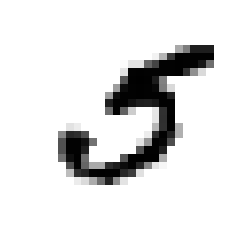

In [111]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28) #our dataset's pictures are 28x28 pixels
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation='nearest')
plt.axis('off')

In [8]:
y[36000]

5

## Splitting the data into training, cv and test sets

In [112]:
#The MNIST dataset is already split into train and test:
X_train, y_train, X_test, y_test = X[:60000], y[:60000], X[60000:], y[60000:]

#### Shuffle the training data to guarantee that all cv folds will be similar

In [10]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifier

#### First we try to classify the digit 5

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [13]:
sgd_clf.predict([some_digit])

array([ True])

In [14]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.96145, 0.9683 , 0.94675])

In [15]:
#Evaluating cv scores:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.96145
0.9683
0.94675


In [16]:
#Implement a dummy estimator that classifies all to non-5
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
from sklearn.model_selection import cross_val_score
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90825, 0.91135, 0.90935])

In [18]:
#Evaluate how this model truely performs
from sklearn.model_selection import cross_val_predict
y_trained_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_trained_pred)

array([[54090,   489],
       [ 1981,  3440]])

In [19]:
#Precision and Recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_trained_pred)

0.8755408500890812

In [20]:
4094 / (4094 + 1238)

0.7678169542385597

In [21]:
recall_score(y_train_5, y_trained_pred)

0.6345692676627929

In [22]:
4094 / (4094 + 1327)

0.7552112156428703

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_trained_pred)

0.7358288770053477

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([12892.01788558])

In [25]:
theshold = 0
y_some_degit_pred = (y_scores > theshold)

In [26]:
y_some_degit_pred

array([ True])

In [27]:
threshold = 200000
y_some_degit_pred = (y_scores > threshold)
y_some_degit_pred

array([False])

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method='decision_function')

In [29]:
y_scores.shape

(60000,)

### Plot the precision recall curve 

In [30]:
from sklearn.metrics import precision_recall_curve

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [43]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth=2)
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', linewidth=2)
    plt.xlabel("Threshold")
    plt.legend(loc='upper_left')
    plt.ylim([0, 1])
    plt.xlim([-700000, 700000])

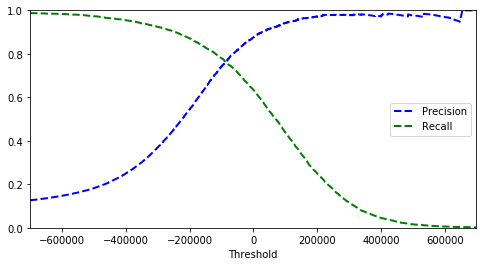

In [44]:
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


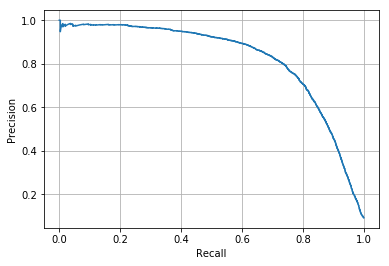

In [47]:
plt.plot(recalls, precisions)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.grid(True)

In [81]:
y_train_pred_90 = (y_scores > 20000)

In [82]:
precision_score(y_train_5, y_train_pred_90)

0.8946206896551724

In [83]:
recall_score(y_train_5, y_train_pred_90)

0.5982291090204759

### Plot ROC curve 

In [85]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
#fpr : false positive rate
#tpr : true positive rate

In [88]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

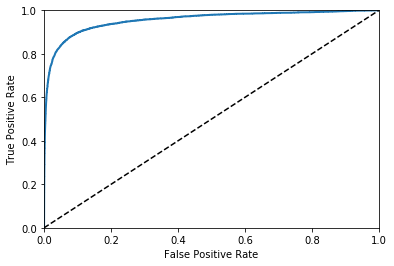

In [89]:
plot_roc_curve(fpr, tpr)

### Compute ROC AUC 

In [90]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9554524821935364

## Train a Random Forest Classifier and compare ROC and ROC AUCs of the two classifiers

In [92]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probs_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                  method='predict_proba')

In [94]:
y_scores_forest = y_probs_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

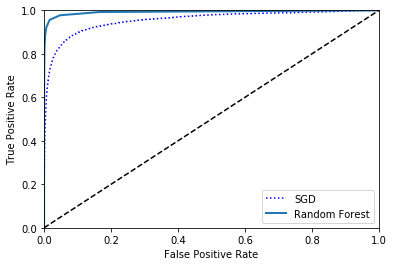

In [96]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc = 'lower right')


In [99]:
roc_auc_score(y_train_5, y_scores_forest)

0.9923620004503353

In [101]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9851900972590628

In [103]:
recall_score(y_train_5, y_train_pred_forest)

0.8221730308061244

## Multiclass classification

In [114]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [115]:
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [116]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -62703.44639676, -460687.57933386, -319518.34098955,
        -114278.16461143, -468462.8389351 ,   44427.85526221,
        -693906.24797703, -372143.79048941, -536909.69073874,
        -462244.00683201]])

In [117]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86157768, 0.86489324, 0.87918188])

### Scaling the inputes

In [118]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()

In [119]:
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [120]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.9070186 , 0.90659533, 0.91193679])

### Confusion matrix

In [123]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5718,    2,   26,    9,   10,   52,   46,   10,   46,    4],
       [   1, 6446,   48,   29,    7,   43,    6,   14,  136,   12],
       [  55,   40, 5301,  105,   80,   31,   92,   59,  179,   16],
       [  42,   41,  142, 5309,    3,  261,   34,   51,  138,  110],
       [  17,   22,   37,    9, 5368,    9,   56,   32,   83,  209],
       [  71,   37,   37,  176,   79, 4631,  103,   24,  158,  105],
       [  28,   21,   44,    2,   46,   94, 5632,    5,   45,    1],
       [  26,   18,   72,   30,   58,   12,    4, 5782,   17,  246],
       [  44,  152,   67,  142,   20,  170,   49,   27, 5026,  154],
       [  39,   30,   27,   89,  158,   31,    2,  199,   76, 5298]])

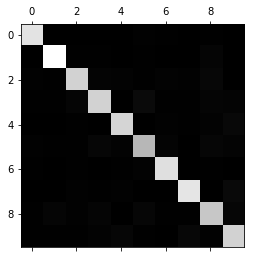

In [124]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

#### Compare error rates

In [125]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

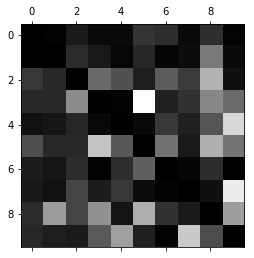

In [126]:
#fill diagonal with zeros to keep errors only
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

## Multilabel Classification

In [129]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [130]:
knn_clf.predict([some_digit])

array([[False,  True]])

### Evaluate F1 score

In [131]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
f1_score(y_train, y_train_knn_pred, average='macro')

0.9671989524961443